# 環境構築

### GPU&バージョン確認

GPUインスタンスに接続できているかを確認します．“GPUゲットだぜ！”と表示されれば問題ありません．

ゲットできなかった場合でも，CPUを使って実験を進めることは可能ですが，学習にとても時間がかかります．ゲットできなかった場合は，しばらく時間を置いてから再度接続を試してみて下さい．

In [ ]:
import tensorflow as tf

if tf.test.gpu_device_name() == "/device:GPU:0":
  print("GPUゲットだぜ！")
else:
  print("逃した…")

print("TensorFlow:", tf.__version__)

GPUゲットだぜ！
TensorFlow: 2.8.0


### データセットの読み込み

画像データは255で割ることにより値が0.0-1.0に収まるように変換します．

ラベルデータは，One-Hot形式に変換します．

In [ ]:
#ドライブをマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#カレントディレクトリに移動
%cd "/content/drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


In [ ]:
import os
import cv2
import numpy as np
import glob as glob
from sklearn.model_selection import train_test_split
from keras.utils import np_utils


#フォルダをクラス名にする
path_1 = "img/training"
path_2 = "img/testing"
folders = os.listdir(path_1)

#フォルダ名を抽出
classes = [f for f in folders if os.path.isdir(os.path.join(path_1, f))]
n_classes = len(classes)


#画像とラベルの格納
X_train = []
Y_train = []
X_test = []
Y_test = []

#訓練画像を読み込みリサイズする
for label,class_name in enumerate(classes):
  files = glob.glob(path_1 + "/" +  class_name + "/*")
  for file in files:
    img = cv2.imread(file)
    img = cv2.resize(img,dsize=(224,224))
    X_train.append(img)
    Y_train.append(label)

#精度を上げるために正規化
X_train = np.array(X_train)
X_train = X_train.astype('float32')
X_train /= 255.0

#ラベルの変換
Y_train = np.array(Y_train)
Y_train = np_utils.to_categorical(Y_train,n_classes)
Y_train[:5]

#テスト画像を読み込みリサイズする
for label,class_name in enumerate(classes):
  files = glob.glob(path_2 + "/" +  class_name + "/*")
  for file in files:
    img = cv2.imread(file)
    img = cv2.resize(img,dsize=(224,224))
    X_test.append(img)
    Y_test.append(label)

#精度を上げるために正規化
X_test = np.array(X_test)
X_test = X_test.astype('float32')
X_test /= 255.0

#ラベルの変換
Y_test = np.array(Y_test)
Y_test = np_utils.to_categorical(Y_test,n_classes)
Y_test[:5]

#学習データの数と特徴量
print(X_train.shape)
#テストデータの数と特徴量
print(X_test.shape)
#学習データ数とクラス
print(Y_train.shape)
#テストデータ数とクラス
print(Y_test.shape)

(258, 224, 224, 3)
(50, 224, 224, 3)
(258, 5)
(50, 5)


# VGG16による転移学習

In [ ]:
#ここからKerasによるニューラルネットワークによる深層学習スタート
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
base_model = VGG16(weights='imagenet')
pp_model = Model(inputs=base_model.input, 
              outputs=base_model.get_layer('fc2').output)
pp_model.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

ニューラルネットワークから特徴量を抽出

In [ ]:
import numpy as np
train_list = []
test_list = []

# fc2層から特徴量を出力（実数ベクトル）
train_list = pp_model.predict(X_train) 
test_list = pp_model.predict(X_test)

# 特徴量リストをNumPy配列に変換
train_list = np.asarray(train_list) 
train_list = train_list.reshape([len(train_list),4096])
# 結果をNumPy形式のファイルに保存
np.save('fc2_VGG16_train.npy',train_list) 

# 特徴量リストをNumPy配列に変換
test_list = np.asarray(test_list) 
test_list = test_list.reshape([len(test_list),4096])
# 結果をNumPy形式のファイルに保存
np.save('fc2_VGG16_test.npy',test_list) 

抽出した特徴量でニューラルネットワークを訓練

In [ ]:
train_list[0]

array([0.        , 0.        , 1.151433  , ..., 0.        , 0.01071286,
       0.5736456 ], dtype=float32)

In [ ]:
# ニューラルネットワークのモデル構築
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization 
from tensorflow.keras.layers import Input, Lambda, Multiply, Add 
from tensorflow.keras.utils import to_categorical

NB_CLASSES = 5
NB_INPUTS = 4096
NB_HIDDEN = 256
NB_BATCH = 128
NB_EPOCHS = 100

a_model = Sequential()
a_model.add(Dense(NB_HIDDEN,input_dim=NB_INPUTS))
a_model.add(Activation('relu'))
a_model.add(BatchNormalization())
a_model.add(Dense(NB_CLASSES,activation='softmax'))
a_compile = a_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 
a_fit = a_model.fit(train_list, Y_train, 
                    epochs=NB_EPOCHS, 
                    batch_size=NB_BATCH,
                    validation_data=(test_list, Y_test))

# DNN特徴量でのモデルと重みをHDF5形式で保存
a_model.save('Potato-Features_1.h5')
a_model.save_weights('Potato-Features-weights_1.h5')

Epoch 1/100
3/3 [==============================] - 2s 96ms/step - loss: 1.7841 - accuracy: 0.3450 - val_loss: 3.0833 - val_accuracy: 0.2600
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6818 - accuracy: 0.7636 - val_loss: 3.7639 - val_accuracy: 0.2000
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4301 - accuracy: 0.8566 - val_loss: 4.2592 - val_accuracy: 0.2200
Epoch 4/100
3/3 [==============================] - 0s 16ms/step - loss: 0.3510 - accuracy: 0.8760 - val_loss: 4.7217 - val_accuracy: 0.2200
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 0.3220 - accuracy: 0.8837 - val_loss: 4.9680 - val_accuracy: 0.2200
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2749 - accuracy: 0.9109 - val_loss: 5.2074 - val_accuracy: 0.2000
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.2392 - accuracy: 0.9225 - val_loss: 5.5850 - val_accuracy: 0.2000
Epoch 8/100
3/3 [===

DNN特徴量からテストデータの所属確率を計算

In [ ]:
# テストデータのクラスへの所属確率
a_pred_P = a_model.predict(test_list, batch_size=128, verbose=1)
# テストデータの所属クラスID(0-4)
classes_x = np.argmax(a_pred_P,axis=1)
print(classes_x)
# テストデータのクラスへの所属確率をNumPy形式で保存
np.save('Potato-Feature-Pred.npy', a_pred_P)
# DNN特徴量で訓練したニューラルネットワークでの平均分類精度の計算
accuracy = a_model.evaluate(test_list, Y_test, batch_size=128, verbose=1)
print('分類精度:DNN(VGG16) = {:.4f}'.format(accuracy[1]))

1/1 [==============================] - 0s 24ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 3 2 2 0 3 3 0 0 0 0 0
 0 0 0 0 0 0 0 3 4 0 0 0 4]
1/1 [==============================] - 0s 21ms/step - loss: 2.9022 - accuracy: 0.3400
分類精度:DNN(VGG16) = 0.3400


混合行列

In [ ]:
# Matplotlibのフォントの制御（大きさや種類）
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix_vgg(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(14,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=25)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=15,
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('predicted value',fontsize=25)
    plt.xlabel('true value',fontsize=25)
    plt.savefig('potato-vgg-ConfusionMatrix.jpg')
    plt.savefig('potato-vgg-ConfusionMatrix.pdf')

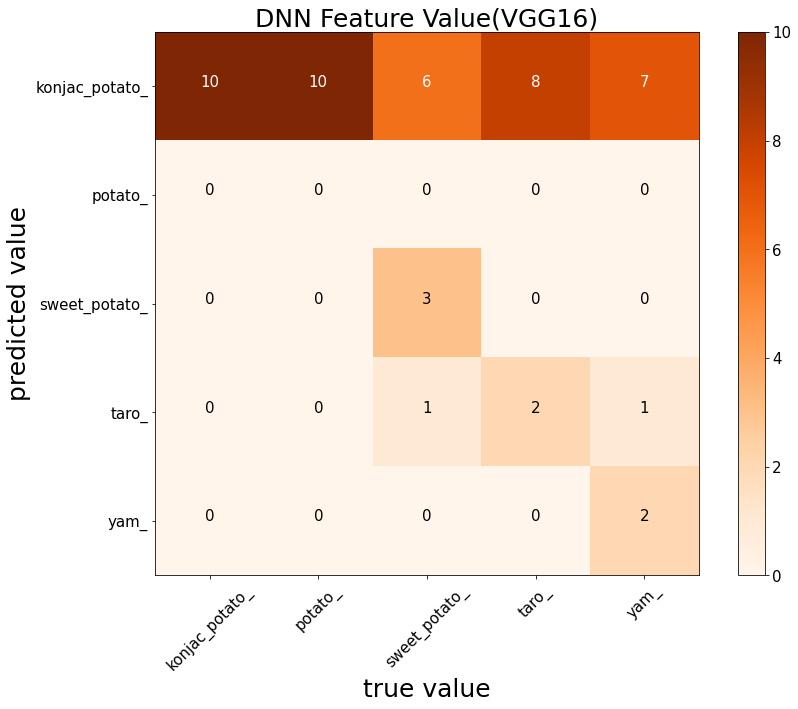

In [ ]:
# VGG16特徴量で訓練したニューラルネットワークでの予測手法の混合行列計算と描画
test_truth = np.argmax(Y_test,axis=1)
a_cm = confusion_matrix(classes_x, test_truth) 
plot_confusion_matrix_vgg(a_cm, classes=classes, title='DNN Feature Value(VGG16)')
plt.show() 

エポック精度グラフ

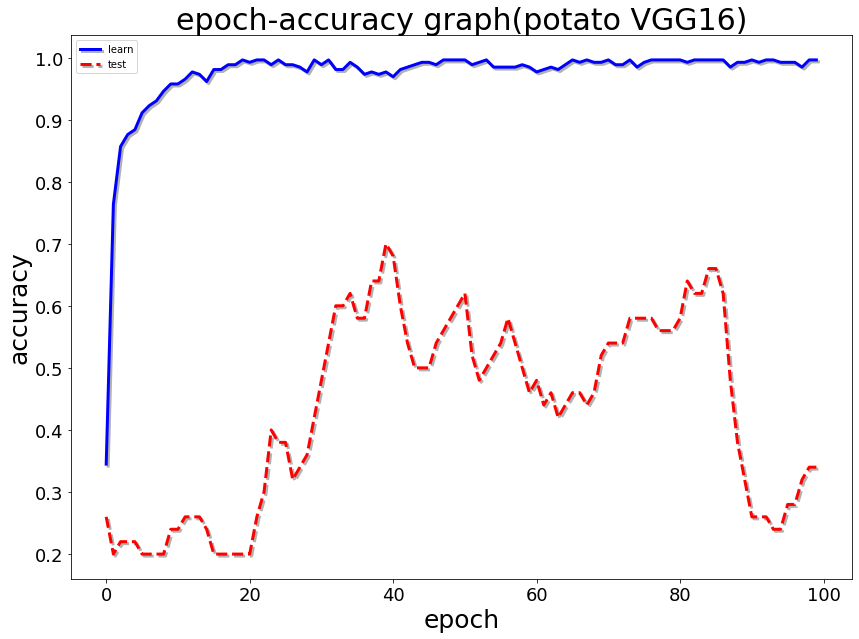

In [ ]:
# エポック精度グラフの描画
plt.figure(figsize=(14,10))

plt.plot(a_fit.history['accuracy'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(a_fit.history['val_accuracy'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.tick_params(labelsize=18)

plt.title('epoch-accuracy graph(potato VGG16)',fontsize=30)
plt.ylabel('accuracy',fontsize=25)
plt.xlabel('epoch',fontsize=25)
plt.legend(['learn', 'test'], loc='best')

plt.savefig('EpochAcc-Potato-VGG16F.pdf')
plt.savefig('EpochAcc-Potato-VGG16F.jpg')

plt.show()

エポック損失グラフ

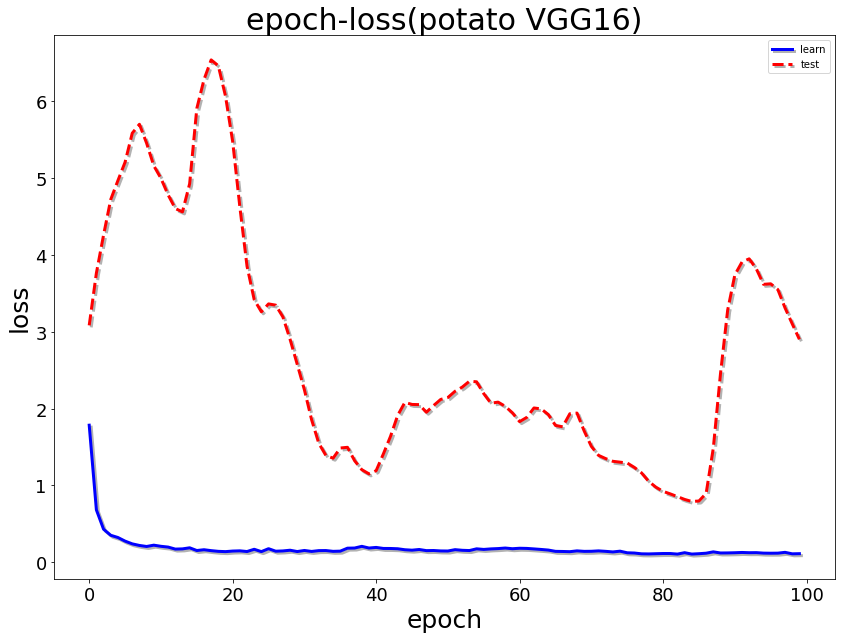

In [ ]:
plt.figure(figsize=(14,10))

plt.plot(a_fit.history['loss'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(a_fit.history['val_loss'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.tick_params(labelsize=18)

plt.title('epoch-loss(potato VGG16)',fontsize=30)
plt.ylabel('loss',fontsize=25)
plt.xlabel('epoch',fontsize=25)
plt.legend(['learn', 'test'], loc='best')

plt.savefig('EpochLoss-Potato-VGG16F.pdf')
plt.savefig('EpochLoss-Potato-VGG16F.jpg')

plt.show()